## Image Stitching

#### Imports

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

#### SIFT feature extraction and matching

In [42]:
def SIFT_features(img1, img5, plot = False):
    # Feature matching with SIFT
    img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_RGB2GRAY)

    # Identify key points of each image
    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1) 

    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors5, k=2)  # Find k best matches
    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append(m)

    plt.figure(figsize = (12, 10))
    plt.subplot(1, 3, 1)
    img1_features = cv.drawKeypoints(img1_gray, keypoints1, img1_gray)
    plt.imshow(img1_features)
    plt.title("Image 1 SIFT features")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    img5_features = cv.drawKeypoints(img5_gray, keypoints5, img5_gray)
    plt.imshow(img5_features)
    plt.title("Image 5 SIFT features")
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    matched_img = cv.drawMatches(img1_gray, keypoints1, img5_gray, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(matched_img)
    plt.title("Matched features between image 1 and 5")
    plt.axis('off')

    return good_matches, keypoints1, keypoints5


#### Finding Inliers

In [45]:
def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis = 1))

    return np.where(errors < thres)[0]

#### Homography computation using RANSAC

In [44]:
def find_best_homography(good_matches, keypoints1, keypoints5):
    # Array of all the matching points
    src_full = []
    dst_full = []

    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))

    src_full = np.array(src_full)
    dst_full = np.array(dst_full)

    # RANSAC for finding best homography
    num_points = 4
    thres = 1
    d = 0.5 * len(good_matches)
    iters = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)

        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))

        src_points = np.array(src_points)
        dst_points = np.array(dst_points)

        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers

#### Load Images

In [46]:
img1 = cv.imread("utils/graf/img1.ppm")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img5 = cv.imread("utils/graf/img5.ppm")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

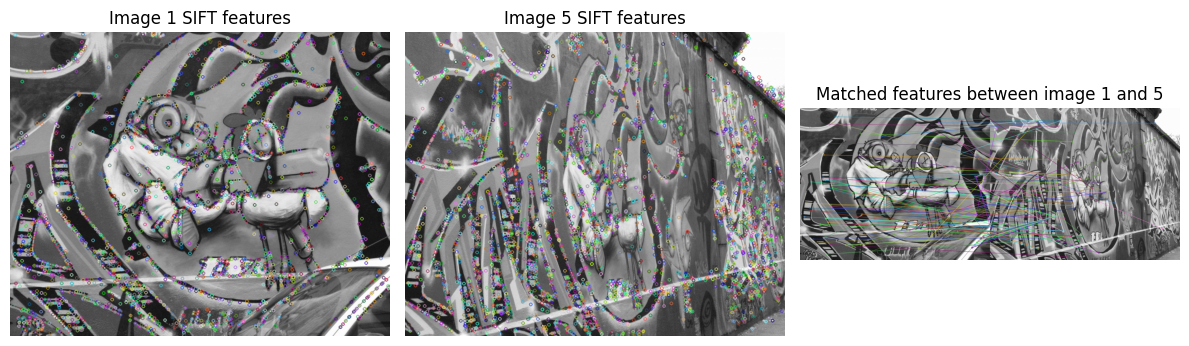

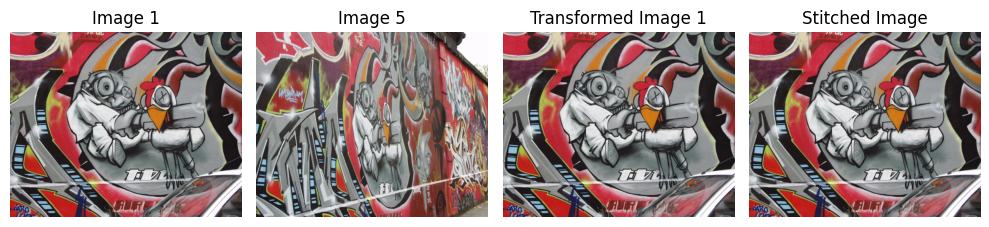

In [47]:
features = SIFT_features(img1, img5, plot = True)

final_transform = transform.ProjectiveTransform(np.identity(3))

final_transformed_image = transform.warp(img1, final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)
mask = (final_transformed_image == 0)
stitched_image = mask * img5 + final_transformed_image

plt.figure(figsize = (10, 10))

plt.subplot(1, 4, 1)
plt.imshow(img1)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img5)
plt.title("Image 5")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(final_transformed_image)
plt.title("Transformed Image 1")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()